In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Load the dataset
df = pd.read_csv("/kaggle/input/undergrad/Undergraduate.csv")

# Assuming the last column is the target variable
target_column = df.columns[-1]

# Remove leading and trailing spaces from the target column
df[target_column] = df[target_column].str.strip()

# Downsample both Public University and Private University to 226 instances each
public_university = df[df['Name of your current institution? '] == 'Public University'].sample(226, random_state=42)
private_university = df[df['Name of your current institution? '] == 'Private University'].sample(226, random_state=42)
balanced_df = pd.concat([public_university, private_university])

# Separate features (X) and target variable (y)
X = balanced_df.drop(columns=[target_column])
y = balanced_df[target_column]

# Identify categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns

# One-hot encode categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), categorical_columns),
        ('passthrough', 'passthrough', [X.columns[0], X.columns[1]])
    ],
    remainder='drop'
)

# Label encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Hyperparameter tuning for each classifier
param_grids = {
    'RandomForestClassifier': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'SVC': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto']
    },
    'MLPClassifier': {
        'hidden_layer_sizes': [(50,), (100, 50), (100, 50, 20)],
        'max_iter': [200, 500, 1000],
        'alpha': [0.0001, 0.001, 0.01]
    },
    'DecisionTreeClassifier': {
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'LogisticRegression': {
        'C': [0.1, 1, 10],
        'max_iter': [50, 100, 200]
    },
    'GaussianNB': {},  # No hyperparameters to tune
    'KNeighborsClassifier': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    },
    'AdaBoostClassifier': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.1, 0.5, 1]
    },
    'GradientBoostingClassifier': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.5],
        'max_depth': [3, 5, 10]
    },
    'XGBClassifier': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.5],
        'max_depth': [3, 5, 10]
    },
    'LGBMClassifier': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.5],
        'max_depth': [3, 5, 10]
    },
    'CatBoostClassifier': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.5],
        'max_depth': [3, 5, 10]
    },
    'ExtraTreesClassifier': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'BaggingClassifier': {
        'n_estimators': [50, 100, 200],
        'max_samples': [0.5, 0.7, 1.0],
        'max_features': [0.5, 0.7, 1.0]
    }
}

# Create pipelines for each classifier
classifiers = {
    'RandomForestClassifier': make_pipeline(preprocessor, RandomForestClassifier(random_state=42)),
    'SVC': make_pipeline(preprocessor, StandardScaler(), SVC(random_state=42)),
    'MLPClassifier': make_pipeline(preprocessor, StandardScaler(), MLPClassifier(random_state=42)),
    'DecisionTreeClassifier': make_pipeline(preprocessor, DecisionTreeClassifier(random_state=42)),
    'LogisticRegression': make_pipeline(preprocessor, StandardScaler(), LogisticRegression(random_state=42)),
    'GaussianNB': make_pipeline(preprocessor, GaussianNB()),
    'KNeighborsClassifier': make_pipeline(preprocessor, StandardScaler(), KNeighborsClassifier()),
    'AdaBoostClassifier': make_pipeline(preprocessor, AdaBoostClassifier(random_state=42)),
    'GradientBoostingClassifier': make_pipeline(preprocessor, GradientBoostingClassifier(random_state=42)),
    'XGBClassifier': make_pipeline(preprocessor, XGBClassifier(random_state=42)),
    'LGBMClassifier': make_pipeline(preprocessor, LGBMClassifier(random_state=42)),
    'CatBoostClassifier': make_pipeline(preprocessor, CatBoostClassifier(random_state=42, verbose=False)),
    'ExtraTreesClassifier': make_pipeline(preprocessor, ExtraTreesClassifier(random_state=42)),
    'BaggingClassifier': make_pipeline(preprocessor, BaggingClassifier(random_state=42))
}

# Perform K-fold cross-validation and generate classification report
def kfold_cross_validation(X, y, classifiers, k=10):
    kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    for name, classifier in classifiers.items():
        print(f"Evaluating {name}...")
        scores = cross_val_score(classifier, X, y, cv=kf, scoring='accuracy')
        print(f"Accuracy: {scores.mean():.2f} (+/- {scores.std() * 2:.2f})")
        predictions = cross_val_predict(classifier, X, y, cv=kf)
        report = classification_report(y, predictions)
        print(f"Classification Report:\n{report}\n{'='*40}\n")

# Perform K-fold cross-validation
kfold_cross_validation(X, y, classifiers)


Evaluating RandomForestClassifier...
Accuracy: 0.80 (+/- 0.08)
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.79      0.80       226
           1       0.79      0.81      0.80       226

    accuracy                           0.80       452
   macro avg       0.80      0.80      0.80       452
weighted avg       0.80      0.80      0.80       452


Evaluating SVC...
Accuracy: 0.77 (+/- 0.13)
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.70      0.75       226
           1       0.73      0.83      0.78       226

    accuracy                           0.77       452
   macro avg       0.77      0.77      0.76       452
weighted avg       0.77      0.77      0.76       452


Evaluating MLPClassifier...


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptro

Accuracy: 0.79 (+/- 0.10)


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptro

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.77      0.78       226
           1       0.78      0.80      0.79       226

    accuracy                           0.79       452
   macro avg       0.79      0.79      0.79       452
weighted avg       0.79      0.79      0.79       452


Evaluating DecisionTreeClassifier...
Accuracy: 0.73 (+/- 0.15)
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.75      0.73       226
           1       0.74      0.70      0.72       226

    accuracy                           0.73       452
   macro avg       0.73      0.73      0.73       452
weighted avg       0.73      0.73      0.73       452


Evaluating LogisticRegression...
Accuracy: 0.79 (+/- 0.11)
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.74      0.78       226
           1       0.77      0.85      0.80 

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from matplotlib.backends.backend_pdf import PdfPages

# Perform K-fold cross-validation and generate classification report along with confusion matrix
def kfold_cross_validation(X, y, classifiers, k=10):
    kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    for name, classifier in classifiers.items():
        print(f"Evaluating {name}...")
        # Perform cross-validation
        scores = cross_val_score(classifier, X, y, cv=kf, scoring='accuracy')
        print(f"Accuracy: {scores.mean():.2f} (+/- {scores.std() * 2:.2f})")
        predictions = cross_val_predict(classifier, X, y, cv=kf)
        report = classification_report(y, predictions)
        print(f"Classification Report:\n{report}\n{'='*40}\n")
        # Generate confusion matrix
        conf_mat = confusion_matrix(y, predictions)
        # Plot confusion matrix using Seaborn
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='inferno', xticklabels=le.classes_, yticklabels=le.classes_)
        plt.title(f'Confusion Matrix for {name}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        # Save plot to PDF file with bbox_inches='tight'
        with PdfPages(f'{name}_confusion_matrix.pdf') as pdf:
            pdf.savefig(bbox_inches='tight')
            plt.close()

# Perform K-fold cross-validation with confusion matrix visualization and save plots to PDF
kfold_cross_validation(X, y, classifiers)

Evaluating RandomForestClassifier...
Accuracy: 0.80 (+/- 0.08)
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.79      0.80       226
           1       0.79      0.81      0.80       226

    accuracy                           0.80       452
   macro avg       0.80      0.80      0.80       452
weighted avg       0.80      0.80      0.80       452


Evaluating SVC...
Accuracy: 0.77 (+/- 0.13)
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.70      0.75       226
           1       0.73      0.83      0.78       226

    accuracy                           0.77       452
   macro avg       0.77      0.77      0.76       452
weighted avg       0.77      0.77      0.76       452


Evaluating MLPClassifier...


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptro

Accuracy: 0.79 (+/- 0.10)


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptro

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.77      0.78       226
           1       0.78      0.80      0.79       226

    accuracy                           0.79       452
   macro avg       0.79      0.79      0.79       452
weighted avg       0.79      0.79      0.79       452


Evaluating DecisionTreeClassifier...
Accuracy: 0.73 (+/- 0.15)
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.75      0.73       226
           1       0.74      0.70      0.72       226

    accuracy                           0.73       452
   macro avg       0.73      0.73      0.73       452
weighted avg       0.73      0.73      0.73       452


Evaluating LogisticRegression...
Accuracy: 0.79 (+/- 0.11)
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.74      0.78       226
           1       0.77      0.85      0.80 

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


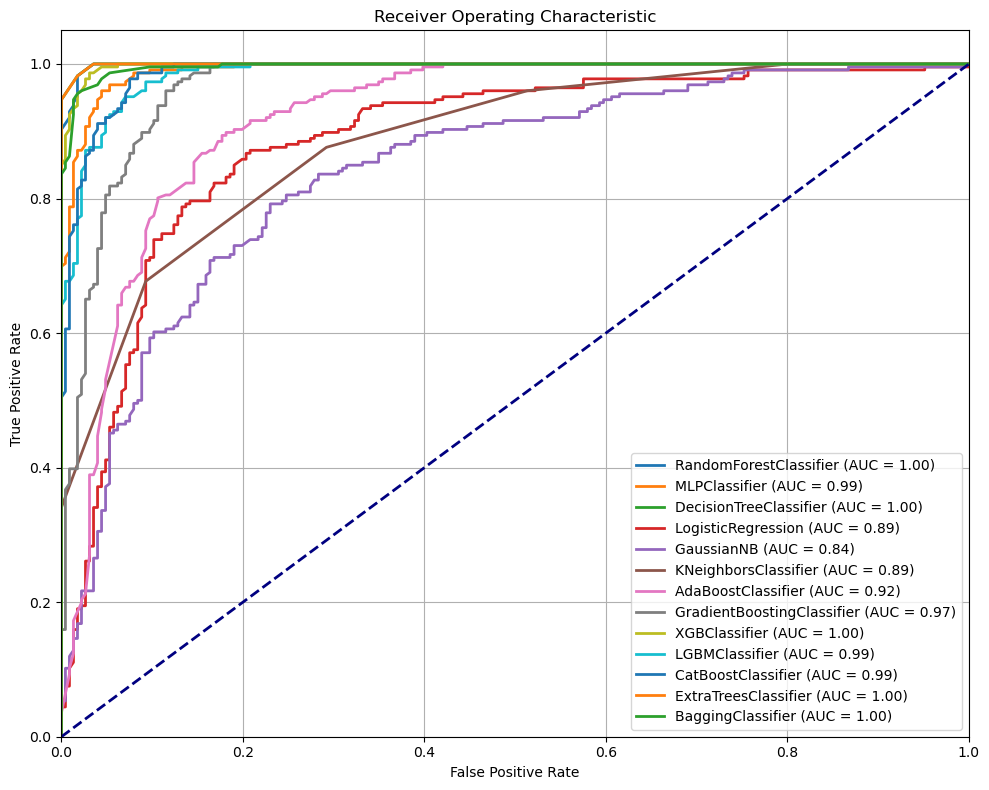

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Function to plot ROC curve for each classifier
def plot_roc_curve(X, y, classifiers):
    plt.figure(figsize=(10, 8))
    for name, classifier in classifiers.items():
        if hasattr(classifier, "predict_proba"):  # Check if the classifier has predict_proba method
            probas = classifier.fit(X, y).predict_proba(X)
            fpr, tpr, thresholds = roc_curve(y, probas[:, 1])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')  # Increased thickness to 2
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Adjust the thickness of the diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("roc_curves.pdf", bbox_inches='tight')
    plt.show()

# Plot ROC curves for all classifiers
plot_roc_curve(X, y, classifiers)

In [5]:
for name, classifier in classifiers.items():
    if name in ['RandomForestClassifier', 'ExtraTreesClassifier', 'GradientBoostingClassifier',
                'XGBClassifier', 'LGBMClassifier', 'CatBoostClassifier']:
        classifier.fit(X, y)
        if name == 'RandomForestClassifier':
            feature_importance = classifier.named_steps['randomforestclassifier'].feature_importances_
        elif name == 'ExtraTreesClassifier':
            feature_importance = classifier.named_steps['extratreesclassifier'].feature_importances_
        elif name == 'GradientBoostingClassifier':
            feature_importance = classifier.named_steps['gradientboostingclassifier'].feature_importances_
        elif name == 'XGBClassifier':
            feature_importance = classifier.named_steps['xgbclassifier'].feature_importances_
        elif name == 'LGBMClassifier':
            feature_importance = classifier.named_steps['lgbmclassifier'].feature_importances_
        elif name == 'CatBoostClassifier':
            feature_importance = classifier.named_steps['catboostclassifier'].feature_importances_
        
        # Create a dictionary to store feature importance with their column names
        feature_importance_dict = dict(zip(X.columns, feature_importance))
        
        # Sort features by their importance (descending order)
        sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
        
        print(f"Feature importance for {name} (most important to least important):")
        for column, importance in sorted_feature_importance:
            print(f"{column}: {importance}")
        print('=' * 40)

Feature importance for RandomForestClassifier (most important to least important):
Did you have other bad habits like smoking/drug addiction?: 0.03831761137260499
What was your SSC GPA?: 0.029191029655479726
Where did you stay when preparing for the exam?: 0.02470972388429828
Did you involve with any type of relationship?: 0.023437258057322385
How was your family's economic condition : 0.022945187252567934
Were there any external factors that may have affected your performance on the test (e.g., personal issues, health concerns, financial challenges)?: 0.018749655314588647
How much time did you spend on social media/other activities while preparing for the exam?: 0.01613282081179711
Were you involved in politics while preparing for the exam?: 0.013435813242178815
How was the educational status of your family?: 0.01203814268002702
What was your HSC GPA?: 0.011792506159421507
Did you stay with your family while preparing for the exam?: 0.011676982081622152
The average duration of study i

Epoch 1/40
23/23 [==============================] - 3s 16ms/step - loss: 0.8519 - accuracy: 0.6011 - val_loss: 0.6330 - val_accuracy: 0.7582
Epoch 2/40
23/23 [==============================] - 0s 7ms/step - loss: 0.6642 - accuracy: 0.6593 - val_loss: 0.6046 - val_accuracy: 0.7582
Epoch 3/40
23/23 [==============================] - 0s 7ms/step - loss: 0.5147 - accuracy: 0.7590 - val_loss: 0.5806 - val_accuracy: 0.7143
Epoch 4/40
23/23 [==============================] - 0s 7ms/step - loss: 0.4600 - accuracy: 0.7784 - val_loss: 0.5537 - val_accuracy: 0.7363
Epoch 5/40
23/23 [==============================] - 0s 7ms/step - loss: 0.5314 - accuracy: 0.7645 - val_loss: 0.5251 - val_accuracy: 0.7473
Epoch 6/40
23/23 [==============================] - 0s 7ms/step - loss: 0.4898 - accuracy: 0.7922 - val_loss: 0.5157 - val_accuracy: 0.7802
Epoch 7/40
23/23 [==============================] - 0s 7ms/step - loss: 0.4127 - accuracy: 0.8116 - val_loss: 0.5142 - val_accuracy: 0.7473
Epoch 8/40
23/23 [=

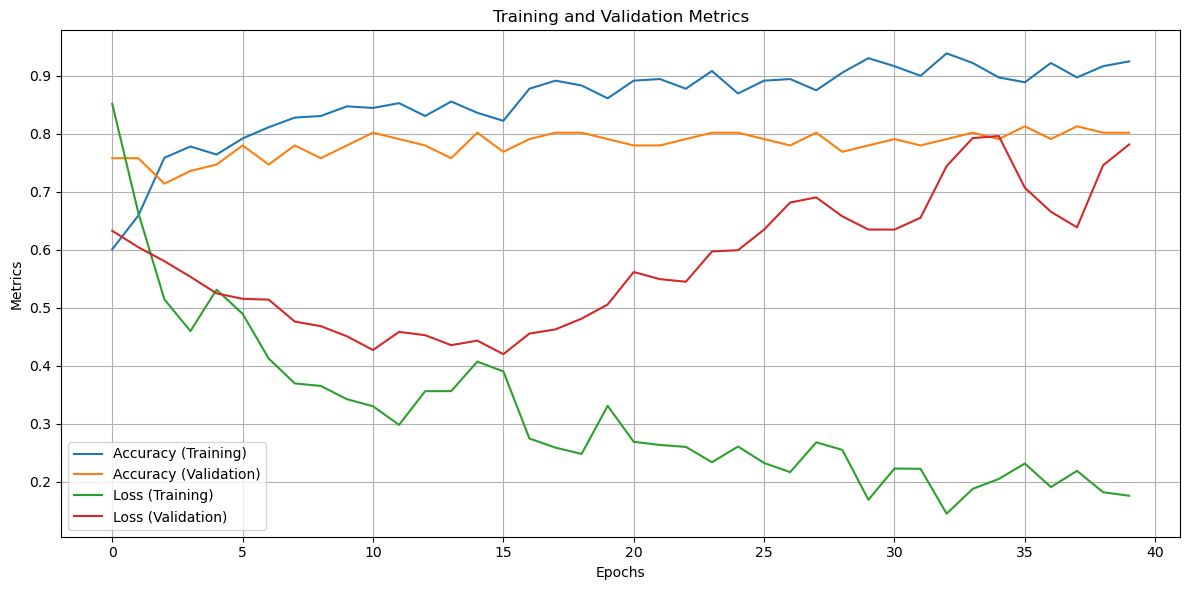

3/3 [==============================] - 0s 2ms/step
For ANN:
Accuracy: 0.8021978021978022
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.86      0.82        49
           1       0.82      0.74      0.78        42

    accuracy                           0.80        91
   macro avg       0.80      0.80      0.80        91
weighted avg       0.80      0.80      0.80        91



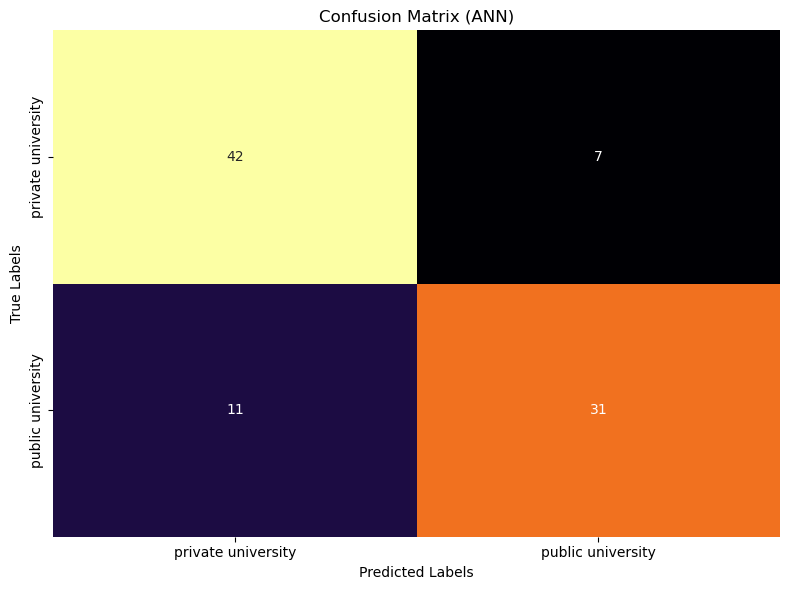

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Load the dataset
df = pd.read_csv("/kaggle/input/undergrad/Undergraduate.csv")

# Downsample both Public University and Private University to 226 instances each
public_university = df[df['Name of your current institution? '] == 'Public University'].sample(226, random_state=42)
private_university = df[df['Name of your current institution? '] == 'Private University'].sample(226, random_state=42, replace=True)
balanced_df = pd.concat([public_university, private_university])

# Assuming the last column is the target variable
target_column = balanced_df.columns[-1]

# Remove leading and trailing spaces from the target column
balanced_df[target_column] = balanced_df[target_column].str.strip()

# Separate features (X) and target variable (y)
X = balanced_df.drop(columns=[target_column])
y = balanced_df[target_column]

# Identify categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns

# One-hot encode categorical columns
X_encoded = pd.get_dummies(X, columns=categorical_columns)

# Label encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Standardize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define a more complex ANN model with Dropout and BatchNormalization
ann_model = Sequential()
ann_model.add(Dense(units=512, activation='relu', input_dim=X_train_scaled.shape[1]))
ann_model.add(BatchNormalization())
ann_model.add(Dropout(0.5))
ann_model.add(Dense(units=256, activation='relu'))
ann_model.add(BatchNormalization())
ann_model.add(Dropout(0.4))
ann_model.add(Dense(units=128, activation='relu'))
ann_model.add(Dropout(0.3))
ann_model.add(Dense(units=64, activation='relu'))
ann_model.add(Dropout(0.2))
ann_model.add(Dense(units=1, activation='sigmoid'))

# Implement learning rate scheduling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9
)
ann_model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='binary_crossentropy', metrics=['accuracy'])

# Train the ANN model and get history
history = ann_model.fit(X_train_scaled, y_train, epochs=40, batch_size=16, validation_data=(X_test_scaled, y_test))

# Visualize accuracy and loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Accuracy (Training)')
plt.plot(history.history['val_accuracy'], label='Accuracy (Validation)')
plt.plot(history.history['loss'], label='Loss (Training)')
plt.plot(history.history['val_loss'], label='Loss (Validation)')
plt.title('Training and Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("train_ann.pdf", bbox_inches='tight')  # Save the confusion matrix as a PDF with tight bounding box
plt.show()


# Predictions using the ANN
y_pred_ann = (ann_model.predict(X_test_scaled) > 0.5).astype("int32").flatten()

# Evaluate the ANN
print('For ANN:')
print('Accuracy:', accuracy_score(y_test, y_pred_ann))
print('Classification Report:')
print(classification_report(y_test, y_pred_ann))

# Plot confusion matrix
class_labels = ['private university', 'public university']
conf_matrix_ann = confusion_matrix(y_test, y_pred_ann)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_ann, annot=True, fmt='d', cmap='inferno', cbar=False)
plt.title('Confusion Matrix (ANN)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(ticks=[0.5, 1.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5], labels=class_labels)
plt.tight_layout()
plt.savefig("confusion_matrix_ann.pdf", bbox_inches='tight')  # Save the confusion matrix as a PDF with tight bounding box
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.under_sampling import RandomUnderSampler

# Load the dataset
df = pd.read_csv("/kaggle/input/undergrad/Undergraduate.csv")

# Assuming the last column is the target variable
target_column = df.columns[-1]

# Remove leading and trailing spaces from the target column
df[target_column] = df[target_column].str.strip()

# Perform Random undersampling to balance the classes
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(df.drop(columns=[target_column]), df[target_column])

# Combine the resampled data into a DataFrame
balanced_df = pd.DataFrame(X_resampled, columns=df.drop(columns=[target_column]).columns)
balanced_df[target_column] = y_resampled

# Separate features (X) and target variable (y)
X = balanced_df.drop(columns=[target_column])
y = balanced_df[target_column]

# Identify categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns

# One-hot encode categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), categorical_columns),
        ('passthrough', 'passthrough', [X.columns[0], X.columns[1]])
    ],
    remainder='drop'
)

# Label encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)



# Perform K-fold cross-validation and generate classification report
def kfold_cross_validation(X, y, classifiers, k=10):
    kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    for name, classifier in classifiers.items():
        print(f"Evaluating {name}...")
        scores = cross_val_score(classifier, X, y, cv=kf, scoring='accuracy')
        print(f"Accuracy: {scores.mean():.2f} (+/- {scores.std() * 2:.2f})")
        predictions = cross_val_predict(classifier, X, y, cv=kf)
        report = classification_report(y, predictions)
        print(f"Classification Report:\n{report}\n{'='*40}\n")

# Perform K-fold cross-validation
kfold_cross_validation(X, y, classifiers)